In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import root_mean_squared_error
from enum import Enum

In [2]:
df = pd.read_csv('./boat_data.csv')
df["Length"] = pd.to_numeric(df["Length"], errors="coerce")
df["num_views"] = pd.to_numeric(df["Number of views last 7 days"], errors="coerce")
df[['currency', 'amount']] = df['Price'].str.extract(r'(\w+)\s+([\d,.]+)')
df['amount'] = df['amount'].str.replace(',', '').astype(float)
exchange_rates = {
    'CHF': 1.26,
    'EUR': 1.18,
    'DKK': 0.16
}
df['normalized_price_usd'] = df.apply(lambda row: row['amount'] * exchange_rates.get(row['currency'], 0), axis=1)
df["Material"] = df["Material"].fillna("")
df["Boat Type"] = df['Boat Type'].fillna("")
df["Boat Type"] = df["Boat Type"].str.split(',').str[0]
df["Type"] = df['Type'].fillna("")
df["Type"] = df["Type"].str.split(',').str[0]
df["Year Built"] = df['Year Built'].fillna(0)
df["Length"] = df['Length'].fillna(0)
df["Width"] = df['Width'].fillna(0)
df["num_views"] = df['num_views'].fillna(0)
df["normalized_price_usd"] = df['normalized_price_usd'].fillna(0)
df = df.drop(columns=['Price', 'amount', 'Number of views last 7 days', 'Location', 'currency', 'Manufacturer'])
types = df['Type'].unique()

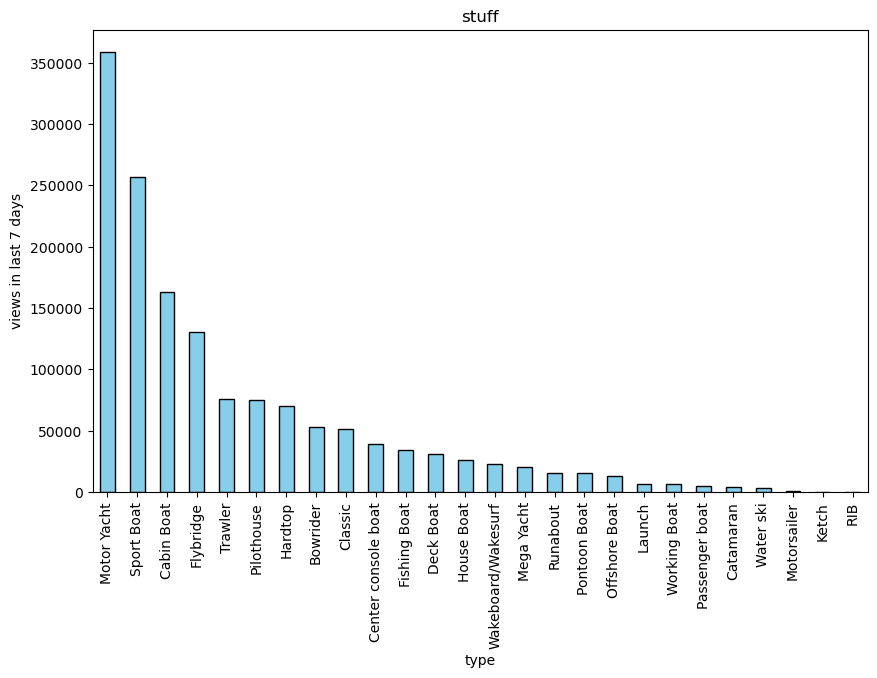

In [3]:
views_by_type = df.groupby("Boat Type")["num_views"].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
views_by_type.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("stuff")
plt.xlabel("type")
plt.ylabel("views in last 7 days")
plt.show()

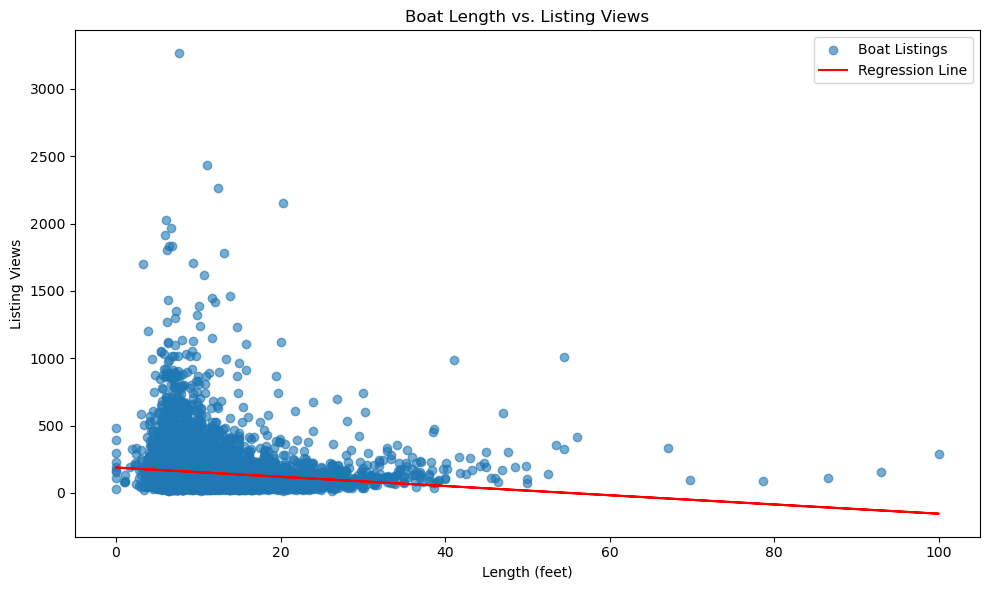

In [4]:
x = df["Length"]
y = df["num_views"]
# Fit a linear regression line
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, label="Boat Listings")
plt.plot(x, regression_line, color="red", label="Regression Line")

# Labels and title
plt.title("Boat Length vs. Listing Views")
plt.xlabel("Length (feet)")
plt.ylabel("Listing Views")
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

In [5]:
x = df.drop(columns=['num_views'])
y = df['num_views']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [7]:
label_encoders = {}
categorical_cols = ['Material', 'Boat Type', 'Type']

for col in categorical_cols:
    le = LabelEncoder()
    x_train[col] = le.fit_transform(x_train[col])
    x_test[col] = le.fit_transform(x_test[col])
    label_encoders[col] = le

In [8]:
rf = RandomForestRegressor(n_estimators=500, max_depth=None, max_features='sqrt')

In [9]:
rf.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=500)

In [10]:
y_pred = rf.predict(x_test)

In [11]:
rmse = root_mean_squared_error(y_pred, y_test)
rmse

143.12602913155706

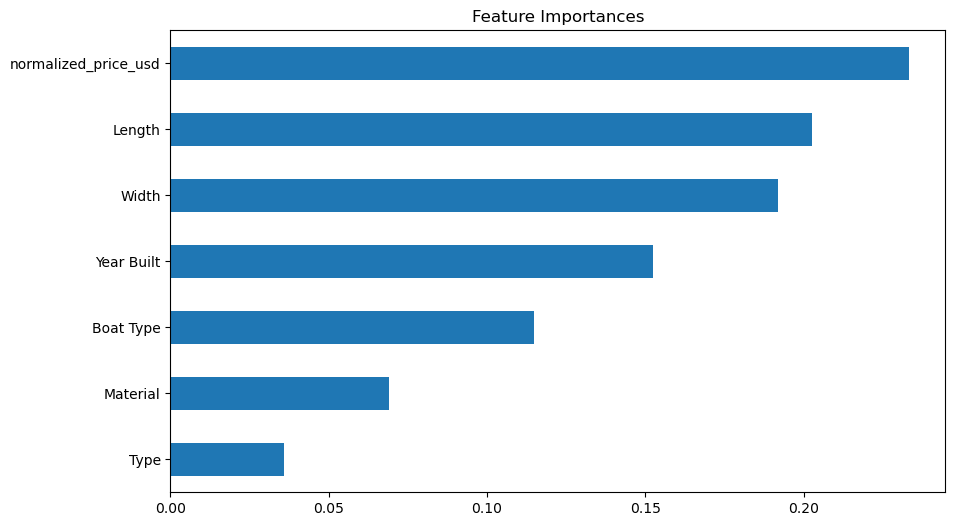

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = x_train.columns
importances = rf.feature_importances_
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importances")
plt.show()

In [13]:
def preprocess_new_data(new_df, label_encoders):
    for col in categorical_cols:
        le = label_encoders[col]
        new_df[col] = new_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    return new_df

In [14]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

In [15]:
form_style={'description_width':'140px'}
form_layout= Layout(width='500px', margin='10px 0px 10px 0px')
length_slider =widgets.IntSlider(min=1,max=60,step=1,description='Boat Length (meters)', orientation='horizontal', readout=True, style=form_style, layout=form_layout)
width_slider = widgets.IntSlider(min=1,max=60,step=1,description='Boat Width (meters)', orientation='horizontal', readout=True, style=form_style, layout=form_layout)
year_built_input = widgets.IntText(description="Year Built", step=1, style=form_style, layout=form_layout)
submit_button = widgets.Button(description="Submit data", disabled=False, button_style='success', style=form_style, layout=form_layout)
boat_type_dropdown = widgets.Dropdown(description='Boat Type', options=label_encoders['Boat Type'].classes_, style=form_style, layout=form_layout)
type_dropdown = widgets.Dropdown(description='idk yet', options=label_encoders['Type'].classes_,style=form_style, layout=form_layout)
material_dropdown = widgets.Dropdown(description='Material', options=label_encoders['Material'].classes_, style=form_style, layout=form_layout)
normalized_price_input = widgets.FloatText(description='Boat Price in US Dollars: ',style=form_style, layout=form_layout)
output = widgets.Output()

def submission_fx(b):
    updated_boat = pd.DataFrame([{
        "Boat Type": boat_type_dropdown.value,
        "Type": type_dropdown.value,
        "Year Built": year_built_input.value,
        "Length": length_slider.value,
        "Width": width_slider.value,
        "Material": material_dropdown.value,
        "normalized_price_usd": normalized_price_input.value
    }])
    with output:
        output.clear_output()
        prediction = rf.predict(preprocess_new_data(updated_boat, label_encoders))
        print(F"Estimated Views: {int(prediction[0])}")
submit_button.on_click(submission_fx)
display(length_slider, boat_type_dropdown,year_built_input, type_dropdown, material_dropdown, normalized_price_input, submit_button, output)


IntSlider(value=1, description='Boat Length (meters)', layout=Layout(margin='10px 0px 10px 0px', width='500px'…

Dropdown(description='Boat Type', layout=Layout(margin='10px 0px 10px 0px', width='500px'), options=('Bowrider…

IntText(value=0, description='Year Built', layout=Layout(margin='10px 0px 10px 0px', width='500px'), style=Des…

Dropdown(description='idk yet', layout=Layout(margin='10px 0px 10px 0px', width='500px'), options=('', 'Diesel…

Dropdown(description='Material', layout=Layout(margin='10px 0px 10px 0px', width='500px'), options=('', 'Alumi…

FloatText(value=0.0, description='Boat Price in US Dollars: ', layout=Layout(margin='10px 0px 10px 0px', width…

Button(button_style='success', description='Submit data', layout=Layout(margin='10px 0px 10px 0px', width='500…

Output()